## Spatial FHN model

In [1]:
import numpy as np 
import scipy as sp
# import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)



In [314]:
def FHN(t, y, return_nullclines=False):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    du = a*u*(u-b)*(1-u) + G.dot(u) - v
    dv = e*(u-v)
    return np.append(du,dv)

In [16]:
T = 500
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
y0[N//2] = 0.7
e = 1e-2 
a, b = (3, 0.2)

For the parameters of the 1 cell system I found from the Parltz book:
aState space of the FitzHugh-Nagumo model (2.6) for a = 3, b = 0.2, I = 0 and ε = 0.01.
At the intersection of the nullclines nu (u) = au(u − b)(1 − u) (green dotted curve) and nw(u) = u
(orange dashed line) a stable fixed point(0, 0) exists. b A perturbation pushing the system state to an
initial condition at (0.19, 0) results in a trajectory that immediately returns to the fixed point (cyan
curve), while a perturbation above threshold (0.21, 0) leads to an excursion before the orbit (purple
curve) returns to the origin 
e For a = 8, b = 0.2, I = 0 and
ε = 0.01 the nullclines intersect at two points and the system is bistable. f With a = 3, b = −0.05,
I0 = 0 and ε = 0.01 the fixed point at the origin becomes unstable and a stable limit cycle occurs
(here shown as a purple trajectory starting at (0, 0.1) and converging to the periodic attractor)

In [10]:
G = np.zeros((N,N))
cells = np.arange(0,N,1)
G[cells,cells] = -4
G[cells,(cells+1)%N] = 1
G[cells,(cells-1)%N] = 1
G[cells,(cells+N_x)%N] = 1
G[cells,(cells-N_x)%N] = 1
G*=0.05

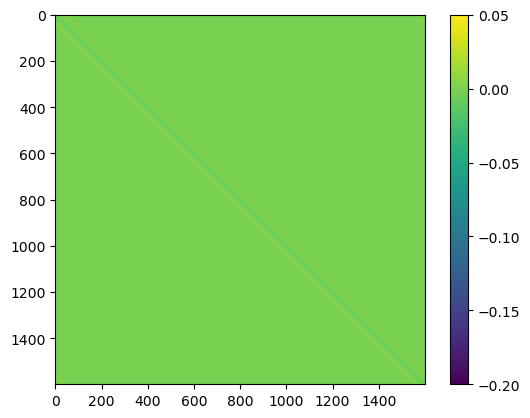

In [11]:
plt.imshow(G)
plt.colorbar()

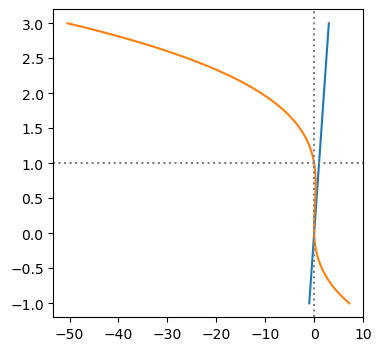

In [12]:
u_array = np.linspace(-1,3,100)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(u_array,u_array)
e = 1e-3
a, b = (3, 0.2)
ax.plot(a*u_array*(u_array-b)*(1-u_array), u_array)
ax.axvline(0, c='grey', ls=':')
ax.axhline(1, c='grey', ls=':')

In [ ]:
out = sp.integrate.solve_ivp(FHN, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

In [ ]:
plt.plot(out['t'],out['y']
         [N//2,:].T)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(out['y'][:N, 20].reshape(N_x,N_y))
plt.colorbar(im)

Idea: use a lattice and the graph laplacian to achieve diffusion. This works if we want a 5 point stencil for the laplacian. Philip says it would be nice to have a nine point stencil for the laplacian laplacian to have a smoother wave diffusion. I don't know how to implement it on networkx so I have tried to do it with sparse matrices.

In [70]:
T = 1000
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
y0[N//2] = 0.3
e = 1e-2 
a, b = (3, 0.2)
Du=2
Dv=2

In [71]:
import networkx as nx

# As I am not very sure what is best to do I'll leave a function to create the lattice
#both with periodic and open boundary conditions. Only useful for 5 point stencil
def lattice_graph(m, periodic=False):
   
    if periodic:
        
        Graph = nx.grid_2d_graph(m, m, periodic=True)
    else:
        
        Graph = nx.grid_2d_graph(m, m)

    # Relabel nodes from (i, j) to a single index in range(m*n)
    mapping = {(i, j): i * m + j for i in range(m) for j in range(m)}
    Graph = nx.relabel_nodes(Graph, mapping)
    
    for u, v in Graph.edges():
        Graph[u][v]['weight'] = 1
    return Graph

Lattice=lattice_graph(N_x, periodic=True)
L = nx.laplacian_matrix(Lattice, weight='weight') #this is a scipy sparse array


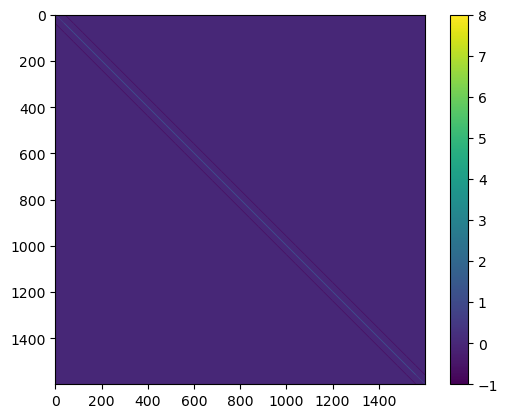

In [72]:

from scipy.sparse import lil_matrix

def graph_laplacian(N,M, boundary_condition="periodic"):

    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  # sparse adjacency matrix
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            # Connect to 8 neighbors (including diagonals)
            neighbors = [
                (i - 1, j),     # up
                (i + 1, j),     # down
                (i, j - 1),     # left
                (i, j + 1),     # right
                (i - 1, j - 1), # top-left
                (i - 1, j + 1), # top-right
                (i + 1, j - 1), # bottom-left
                (i + 1, j + 1)  # bottom-right
            ]
            
            for ni, nj in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions
                    if 0 <= ni < N and 0 <= nj < M:
                        adj_matrix[idx, node_index(ni, nj)] = 1
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = 1

    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = lil_matrix(np.diag(degrees))
    
    # Laplacian: L = D - A
    laplacian_matrix = degree_matrix - adj_matrix
    return laplacian_matrix

L=graph_laplacian(N_x, N_y)
Ld=L.todense()
plt.imshow(Ld)
plt.colorbar()


### Wave
Periodic boundary conditions, excitation in the middle.

## Spiral
no flux boundary condition. Excite all the left boundary, let the wave propagate up to the middle of the frame. Then initialise to zero the u variable in the lower half of the frame. The spiral should form. Otherwise, also with no flux boundary conditions we can exctite the left half of the frame, then initialise the lower half of the frame with a v variable in the refractory period. This however would require playing around with parameters.

 Actually having a look at this nice review : https://arxiv.org/pdf/2404.11403
They don't introduce noise and Philipp says we should not put it.
Instead it is apparently necessary to introduce diffusion on the slow variable. Problem is that there is no directed mapping between their equations and ours: Philip says to first try with ours and if it doesn't work we can try with their and change the equations in the main text.

In [115]:
#the FHN equations would become
def FHN_graph(t, y):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]

    
    du = a*u*(u-b)*(1-u) - Du*L.dot(u) - v 
    dv = e*(u-v-Dv*L.dot(v))

    return np.append(du,dv)

In [74]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

C:\Users\pelli\anaconda3\lib\site-packages\scipy\integrate\_ivp\bdf.py:407: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


looking at sparse matrices I also found out that if we don't want an exact solution cause the system is too big we can use something which is called the conjugate matrix method:
from scipy.sparse.linalg import cg
x, info = cg(L, u)
and x is the wanted matrix product

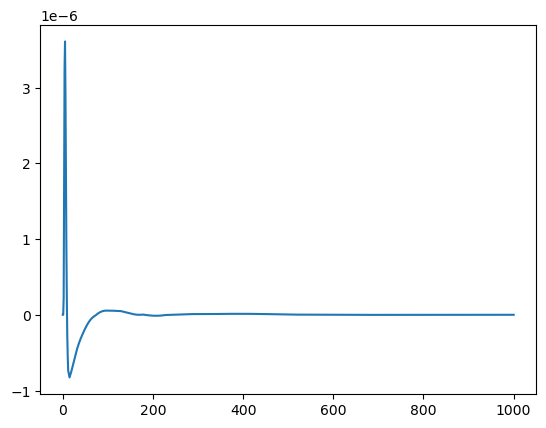

In [79]:
plt.plot(out['t'],out['y']
         [1,:].T)
##print(np.where(out['y'][N//2+1,:].T>0))

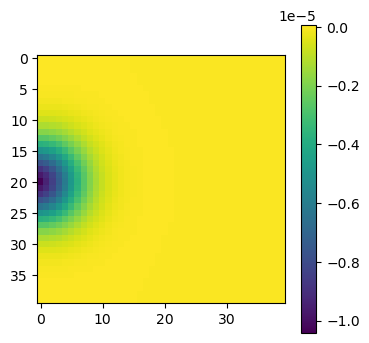

In [78]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(out['y'][:N,100].reshape(N_x,N_y))
plt.colorbar(im)

I guess this is quite cool cause we see the wave and although it does not invade the whole system it still goes around a bit and actually the action potential of the first neuron is gone when the wave propagates and goes back


## Spiral

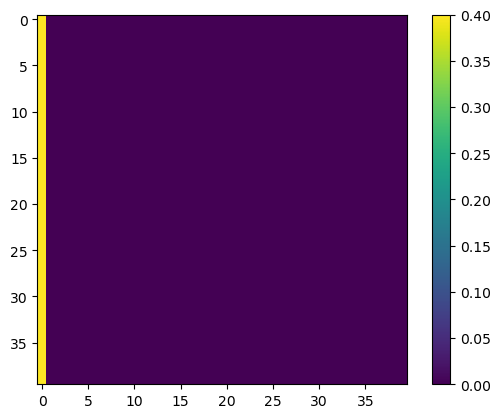

In [156]:
L=graph_laplacian(N_x, N_y, "no-flux")
T = 500
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0:
        y0[i]=0.4

e = 1e-2 
a, b = (3, 0.2)
Du=10
Dv=10
y=y0[:N].reshape(N_x, N_y)
plt.imshow(y)
plt.colorbar()

In [157]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

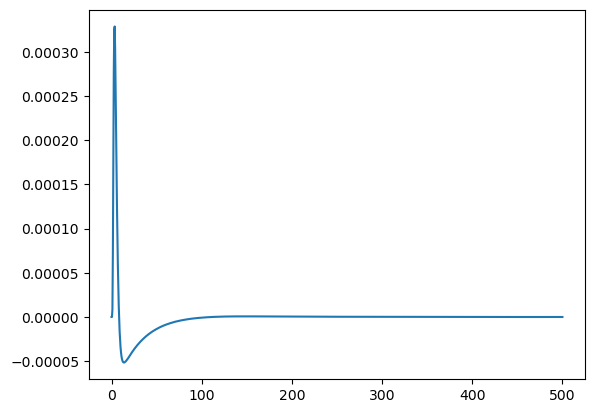

In [158]:
plt.plot(out['t'],out['y']
         [N_x+30,:].T)
##print(np.where(out['y'][N//2+1,:].T>0))
plt.show()

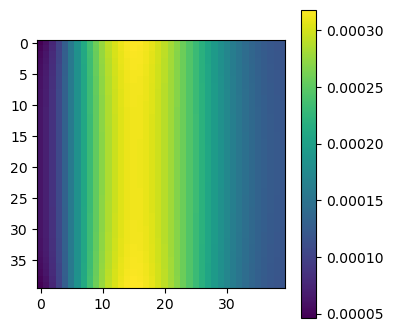

In [164]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(out['y'][:N,11].reshape(N_x,N_y))
plt.colorbar(im)

# 

In [ ]:
init=out['y'][:,11]

In [157]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), init, t_eval=np.linspace(0, T, plot_n), method='BDF')

## Brain

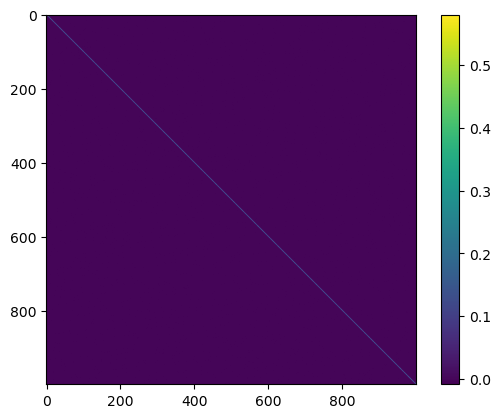

In [263]:
#random network implementation
import random

#if we want a ER graph: Johannes says that this is what we find in literature
# for N=10000 we should choose k=100-1000 k=mean degree
def random_graph(N, k):

    p = k / (N - 1)
    
    G = nx.erdos_renyi_graph(N, p)
    # Random weight between 0 and 1:at the moment we stick with excitatory, then maybe we'll also
    #put inhibition
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0, 1)*J 
    
    return G
N = 1000
k=100
c=4
J=0.21/k*c  #defines the strength of the connection. 0.21 should be the threshold for excitation
Network=random_graph(N,k)
L = nx.laplacian_matrix(Network, weight='weight') 
L_d=L.todense()
plt.imshow(L_d)
plt.colorbar()
plt.show()

In [269]:
T = 1000
plot_n = 100
y0 = np.zeros(2*N)
#y0[N//2] = 0.22
e = 1e-2 
a, b = (3, 0.2)
D=0.3 #should be just above the threshold, is the noise strength
precomputed_eta = np.random.normal(0, 1, (plot_n*1000, N))


### For noise strength:
If the perturbations of an excitable system are due to noise the
system is now and then kicked above threshold and excursions occur randomly. For
noise amplitudes close to the threshold, however, this happens in a relatively regular
manner resembling a periodic motion (to some extent). This phenomenon is called
coherence resonance

### For parameters used by FH for neuron model:
A.S. Pikovsky, J. Kurths, Coherence resonance in a noise-driven excitable system. Phys. Rev.
Lett. 78, 775–778 (1997)
### For parameters for stochastic resonance
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.78.775

Problem is that they all use a different version of FHN equations (i.e. simplifying them)

Johannes also says that for neurons we should add a time delay

### problems
I have a problem when I implement the noise: if I evaluate it at every timestep the simulation takes forever. Hence I have tried to make up something which allows me to calculate the noise matrix first and then integrate. I still have some doubts though because although the matrix should be big enough for the timeframe considered it usually isn't. Could this be due to the fact that the integrator does intermediate timesteps? Please feel free to change the code!


In [270]:
#the FHN equations with noise and time delay
from collections import deque
u_history = deque(maxlen=3) #here I consider a time delay of 3 integration timesteps (duration AP)
#I have put noise in the fast variable as in this way we can make a parallel with an "external input"


def FHN_graph_noise(t, y, dt):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]

    u_history.append(u.copy())

    # Use u from 3 time steps ago if available, otherwise use the current u
    if len(u_history) < 3:
        u_delayed = u
    else:
        u_delayed = u_history[0]
    
    dt = min(dt, plot_n - 1)
    eta=precomputed_eta[int(dt)]
    dt=dt+1
    
    du = a*u*(u-b)*(1-u) - L.dot(u_delayed) - v +D*eta
    dv = e*(u-v)
    return np.append(du,dv)


In [271]:
def solve_with_precomputed_noise():
    dt = 0  
    
    def FHN_graph(t, y):
        nonlocal dt
        dydt = FHN_graph_noise(t, y, dt)
        dt += 1  # Increment the noise step for the next call
        
        return dydt
    
    sol = sp.integrate.solve_ivp(FHN_graph,  (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='RK45',  rtol=1e-5, atol=1e-8)
    return sol


out = solve_with_precomputed_noise()

In [272]:
u_sol = out.y[:N, :]  # u over time
v_sol = out.y[N:, :]  # v over time

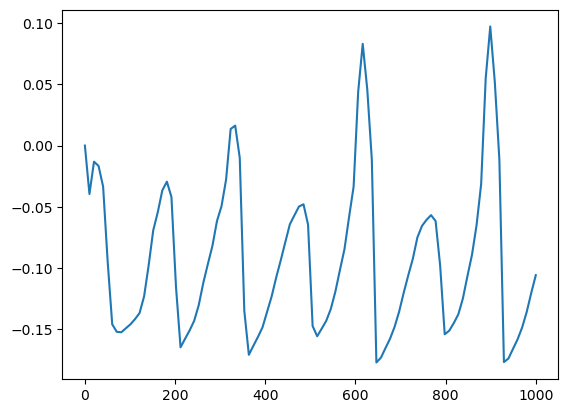

In [273]:
plt.plot(out['t'],u_sol.T[:,1])
plt.show()

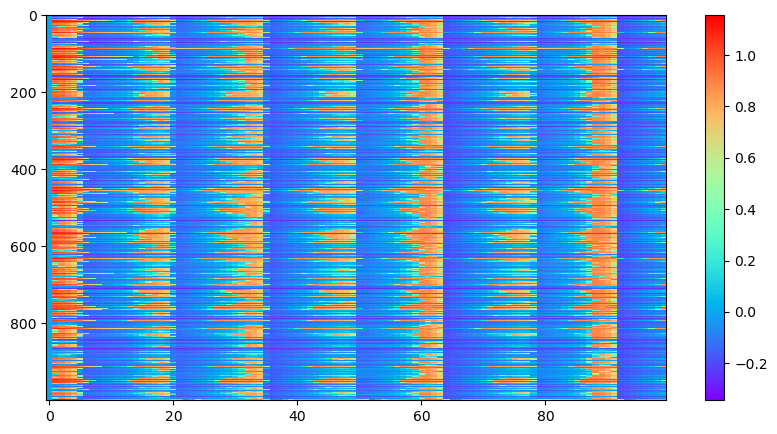

In [274]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)


well turns out we are getting pretty synchronised activity have checked and different realisations look different! Problem: I don seem to be able to get them out of synchronisation

In [303]:
N = 1000
k=100
J=0.21/(k*1000) #defines the strength of the connection. 0.21 should be the threshold for excitation
Network=random_graph(N,k)
L = nx.laplacian_matrix(Network, weight='weight') 
D=0.001
precomputed_eta = np.random.normal(0, 1, (plot_n*1000, N))


In [304]:
u_history = deque(maxlen=100) #here I consider a time delay of 3 integration timesteps (duration AP)
#I have put noise in the fast variable as in this way we can make a parallel with an "external input"


def FHN_graph_noise(t, y, dt):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    

    u_history.append(u.copy())

    # Use u from 3 time steps ago if available, otherwise use the current u
    if len(u_history) < 100:
        u_delayed = u
    else:
        u_delayed = u_history[0]
    dt = min(dt, plot_n - 1)
    eta=precomputed_eta[int(dt)]
    dt=dt+1
    
    du = a*u*(u-b)*(1-u) - L.dot(u_delayed) - v +D*eta
    dv = e*(u-v)
    return np.append(du,dv)


In [305]:
out = solve_with_precomputed_noise()

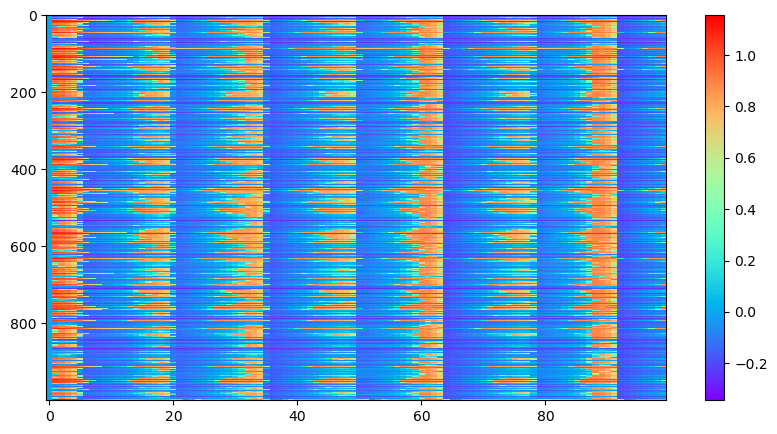

In [306]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# heatmap with 
im = ax.imshow(u_sol, aspect='auto', cmap='rainbow', interpolation='none')

# plot colorbar
cbar = fig.colorbar(im, ax=ax)
